**Author:** Regina Hoo

**Institution:** Wellcome Sanger institute

**April, 2023**

---

## 25-10-2023
## Malaria parasites single cell DEG: Comparing pf_b versus pf_iv for late trophozoite stage

In [1]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.0.5”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps

In [2]:
#anndata <- readRDS('./output/rna4_annotate_LT_400.rds')
#anndata <- readRDS('./output/rna4_annotate_LT_450.rds')
#anndata <- readRDS('./output/rna4_annotate_LT_cutoff.rds')
anndata <- readRDS('./output/rna4_annotate_LT_F.rds')
anndata

An object of class Seurat 
5515 features across 26447 samples within 1 assay 
Active assay: originalexp (5515 features, 0 variable features)

In [3]:
Idents(anndata)= anndata$stage_1

In [4]:
head(Idents(anndata))

Pla_HDBR11345021_AAACCCAAGCGTGCCT Pla_HDBR11345021_AAACCCAAGCTGTGCC 
                            pf_iv                             pf_iv 
Pla_HDBR11345021_AAACCCAAGGGAGGTG Pla_HDBR11345021_AAACCCACACGCTATA 
                            pf_iv                             pf_iv 
Pla_HDBR11345021_AAACCCACACTATCCC Pla_HDBR11345021_AAACCCACAGTTGAAA 
                            pf_iv                             pf_iv 
Levels: pf_b pf_iv pf_nb

# Late trophozoites

In [5]:
LT= subset(x = anndata, idents = c("pf_iv", "pf_b"))
Idents(object = LT) <- "infection"

In [6]:
#fixxing levels
#ET$idc_new.stage_1 = factor(ET$idc_new.stage_1, levels = c("2_early_trophozoite-pf_iv", "2_early_trophozoite-pf_nb", "2_early_trophozoite-pf_b"))
LT$idc_new<- factor(LT$idc_new, levels = c("3_late_trophozoite"))
#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in pf_b
LT$stage_1<- factor(LT$stage_1, levels = c("pf_iv","pf_b"))
#LT$stage_1<- factor(LT$stage_1, levels = c("pf_b","pf_iv"))
LT$classification = paste(LT$idc_new, LT$stage_1, sep='-') # split celltype by disease status


In [7]:
# estimate % cells expressing a gene in each class
plot <- DotPlot(object = LT, features = rownames(LT), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

Warning message:
“Scaling data with a low number of groups may produce misleading results”


In [8]:
head(percent_mat)

,3_late_trophozoite-pf_b,3_late_trophozoite-pf_iv
PF3D7-1400100,1.76446451,4.25644515
RIF,0.04103406,0.05292205
RIF-1,0.00000000,0.01512059
RIF-2,0.00000000,0.01512059
RIF-3,0.12310217,0.09828381
RIF-4,0.04103406,0.05292205


In [9]:
table(LT[["stage_1"]] )


pf_iv  pf_b 
13227  2437 

In [10]:
anndata_sce <- as.SingleCellExperiment(LT)

In [11]:
anndata_sce

class: SingleCellExperiment 
dim: 5515 15664 
metadata(0):
assays(2): counts logcounts
rownames(5515): PF3D7-1400100 RIF ... RIF-181 VAR-79
rowData names(0):
colnames(15664): Pla_HDBR11345021_AAACCCAAGCGTGCCT
  Pla_HDBR11345021_AAACCCAAGCTGTGCC ...
  Pla_HDBR13007973_TTTGTTGCACGGTGAA Pla_HDBR13007973_TTTGTTGCACTATCCC
colData names(39): orig.ident nCount_originalexp ... classification
  ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [12]:
# generate 3 metacells for each donor-celltype combination. This is for pseudobulk.
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$stage_1, 
                                colData(anndata_sce)$idc_new, 
                                colData(anndata_sce)$p_batch, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')

## aggregateAcrossCells here it is only aggregated by celltype, genotype
## this creates the pseudobulk counts
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]

#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$stage_1)
table(summed$classification)


,pf_b-3_late_trophozoite-p_batch1-1,pf_b-3_late_trophozoite-p_batch1-2,pf_b-3_late_trophozoite-p_batch1-3,pf_b-3_late_trophozoite-p_batch2-1,pf_b-3_late_trophozoite-p_batch2-2,pf_b-3_late_trophozoite-p_batch2-3,pf_b-3_late_trophozoite-p_batch7-1,pf_b-3_late_trophozoite-p_batch7-2,pf_b-3_late_trophozoite-p_batch7-3,pf_iv-3_late_trophozoite-p_batch1-1,pf_iv-3_late_trophozoite-p_batch1-2,pf_iv-3_late_trophozoite-p_batch1-3,pf_iv-3_late_trophozoite-p_batch2-1,pf_iv-3_late_trophozoite-p_batch2-2,pf_iv-3_late_trophozoite-p_batch2-3,pf_iv-3_late_trophozoite-p_batch7-1,pf_iv-3_late_trophozoite-p_batch7-2,pf_iv-3_late_trophozoite-p_batch7-3
PF3D7-1400100,3,4,7,1,4,1,8,8,8,41,48,54,167,114,130,31,25,17
RIF,0,0,0,0,0,0,1,0,0,3,0,1,1,0,1,1,0,0
RIF-1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0



pf_iv  pf_b 
    9     9 


 3_late_trophozoite-pf_b 3_late_trophozoite-pf_iv 
                       9                        9 

In [13]:
summed

class: SingleCellExperiment 
dim: 5515 18 
metadata(0):
assays(1): counts
rownames(5515): PF3D7-1400100 RIF ... RIF-181 VAR-79
rowData names(0):
colnames(18): pf_b-3_late_trophozoite-p_batch1-1
  pf_b-3_late_trophozoite-p_batch1-2 ...
  pf_iv-3_late_trophozoite-p_batch7-2
  pf_iv-3_late_trophozoite-p_batch7-3
colData names(43): orig.ident nCount_originalexp ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [14]:
summed$stage_1<- factor(summed$stage_1, levels = c("pf_iv","pf_b"))
#summed$stage_1<- factor(summed$stage_1, levels = c("pf_b", "pf_iv"))

In [15]:
table(summed$stage_1)


pf_iv  pf_b 
    9     9 

In [16]:
y <- DGEList(counts(summed), samples=colData(summed)$metacell_id)

In [17]:
keep <- filterByExpr(y, group=summed$p_batch, min.prop = 0.2)

In [18]:
genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed$classification) ], 1, max) > 20 ] 
# get genes with > 20% expressed cells in the celltypeOf_interest
keep <- keep & names(keep) %in% genes20percent
y <- y[ keep ,]

In [19]:
y <- edgeR::calcNormFactors(y)

In [20]:
summary(keep)

   Mode   FALSE    TRUE 
logical    2592    2923 

In [21]:
design <- model.matrix(~summed$p_batch+summed$stage_1)

# stimate dispersion
y <- estimateDisp(y,design)

# Have a look
head(design)

,(Intercept),summed$p_batchp_batch2,summed$p_batchp_batch7,summed$stage_1pf_b
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,1,0,1
5,1,1,0,1
6,1,1,0,1


In [22]:
# (4) Do limma DEG
fit <- glmQLFit(y, design)
qlf <- glmQLFTest(fit)
topTags(qlf)

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14-3-3I,-1.1220126,8.111305,304.9699,5.374932e-13,1.285379e-09
PF3D7-0202400,1.1773340,9.611211,288.3440,8.794932e-13,1.285379e-09
PF3D7-1476200,2.2375656,6.967375,219.4201,9.458324e-12,7.644001e-09
PF3D7-1401200,0.8358763,7.837301,216.8688,1.046049e-11,7.644001e-09
H2A,0.6626586,15.071330,205.6682,1.649579e-11,9.643440e-09
SHMT-1,-0.8901967,8.888092,198.9669,2.190443e-11,1.067111e-08
PF3D7-1307600,0.6657757,7.706041,184.5009,4.167998e-11,1.740437e-08
PF3D7-0810000,-1.1354409,7.476924,149.4073,2.459132e-10,8.985054e-08
PF3D7-0903700,-0.7052180,8.190934,142.8235,3.575586e-10,1.161271e-07


In [23]:
 ##  Adjust P values using bonferroni and BH
limma_de = qlf$table
limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")

In [24]:
# order table by P-value
limma_de= limma_de[ order(limma_de$p_val_adj, decreasing = FALSE), ]
#limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
#imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

In [25]:
##  Saving the DEG matrices
write.table(limma_de,'./output/1_DEGs_limma_SC_MAL_LT_Final.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)

### Checking the stats of the latest tested celltype

In [26]:
#colData(summed_celltype)$metacell_id

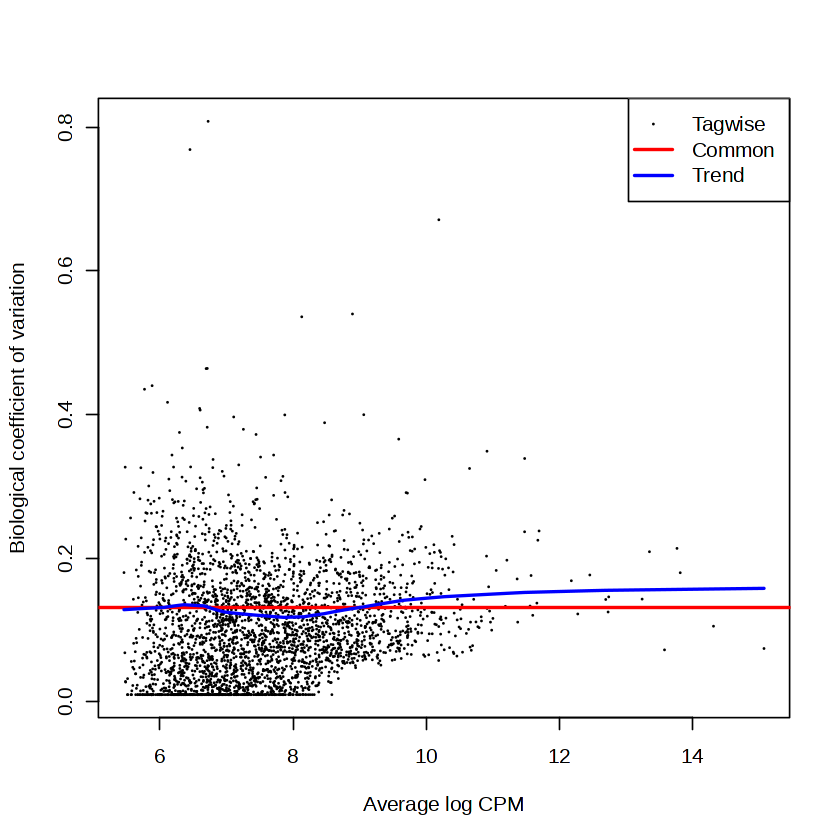

In [27]:
plotBCV(y)

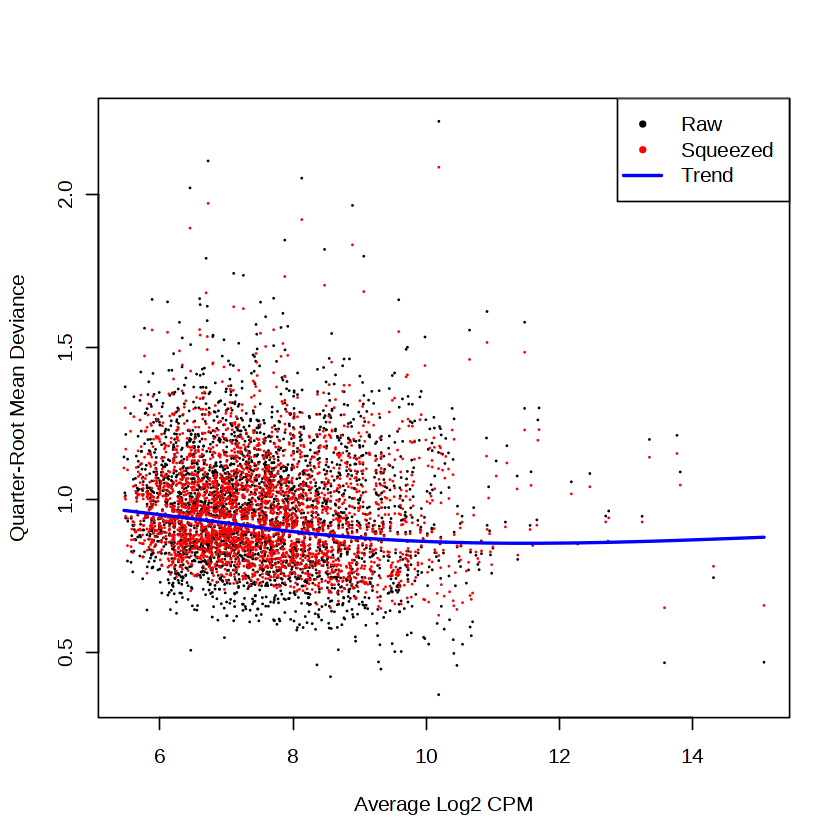

In [28]:
plotQLDisp(fit)

In [29]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,pf_b-3_late_trophozoite-p_batch1-1,pf_b-3_late_trophozoite-p_batch1-2,pf_b-3_late_trophozoite-p_batch1-3,pf_b-3_late_trophozoite-p_batch2-1,pf_b-3_late_trophozoite-p_batch2-2,pf_b-3_late_trophozoite-p_batch2-3,pf_b-3_late_trophozoite-p_batch7-1,pf_b-3_late_trophozoite-p_batch7-2,pf_b-3_late_trophozoite-p_batch7-3,pf_iv-3_late_trophozoite-p_batch1-1,pf_iv-3_late_trophozoite-p_batch1-2,pf_iv-3_late_trophozoite-p_batch1-3,pf_iv-3_late_trophozoite-p_batch2-1,pf_iv-3_late_trophozoite-p_batch2-2,pf_iv-3_late_trophozoite-p_batch2-3,pf_iv-3_late_trophozoite-p_batch7-1,pf_iv-3_late_trophozoite-p_batch7-2,pf_iv-3_late_trophozoite-p_batch7-3
14-3-3I,121.62550,133.84361,138.36437,220.73704,215.83790,219.74658,152.29241,162.93195,140.28061,343.33751,345.73800,338.80080,420.28125,430.89236,431.54908,295.90918,300.21182,294.45105
PF3D7-0202400,501.86522,523.73588,493.24335,549.59017,635.06150,777.90288,2226.55361,2118.11534,2327.30596,261.94243,265.82455,265.12183,269.77746,279.72327,273.24213,824.38307,935.66829,875.67575
PF3D7-1476200,67.85423,87.28931,64.05758,90.09675,174.33061,109.87329,620.73616,490.66863,605.06575,23.42028,23.25110,24.69572,15.44220,19.34964,16.26441,113.56759,104.12533,114.25785
PF3D7-1401200,252.21288,248.77454,245.98110,319.84346,319.60612,285.67055,345.06762,383.92011,393.79977,134.85860,132.96112,132.05067,148.77518,157.33678,160.15025,226.68272,237.44468,253.80597
H2A,46089.66292,43622.83435,44986.35562,46832.29020,50393.99799,45795.18664,34084.58386,34406.73306,34348.46704,26706.12988,26712.09483,27098.65530,30321.78848,29953.60987,29870.13570,22709.89856,23308.50423,22795.56954
SHMT-1,265.01556,251.68419,278.00989,436.96923,415.07288,457.07288,281.45180,282.78994,273.80070,452.85613,472.05595,468.40231,713.33725,700.94081,683.97276,629.37259,639.83557,615.99883
PF3D7-1307600,257.33395,266.23241,238.29419,274.79508,228.29008,263.69589,287.23505,297.77218,302.53287,165.38175,171.45244,167.25738,163.87166,169.06750,160.15025,168.31531,174.19098,178.83837
PF3D7-0810000,85.77798,100.38271,103.77328,63.06772,70.56239,149.42767,133.01489,97.38461,111.54843,200.70415,208.77143,209.50543,223.56612,220.34406,221.08758,255.64020,234.03871,251.09630
PF3D7-0903700,170.27570,183.30756,178.08007,306.32895,244.89300,338.40973,154.22016,177.91420,148.73125,289.10612,284.77713,283.38850,533.33195,532.47798,540.84593,238.44670,245.22975,233.03181
RPN9,188.19946,187.67202,174.23661,220.73704,219.98862,232.93137,294.94606,297.77218,287.32172,286.51453,272.37003,282.16392,379.94716,376.10868,378.74395,404.04725,388.76701,392.45087


In [30]:
summary(decideTests(qlf))

       summed$stage_1pf_b
Down                  500
NotSig               1931
Up                    492

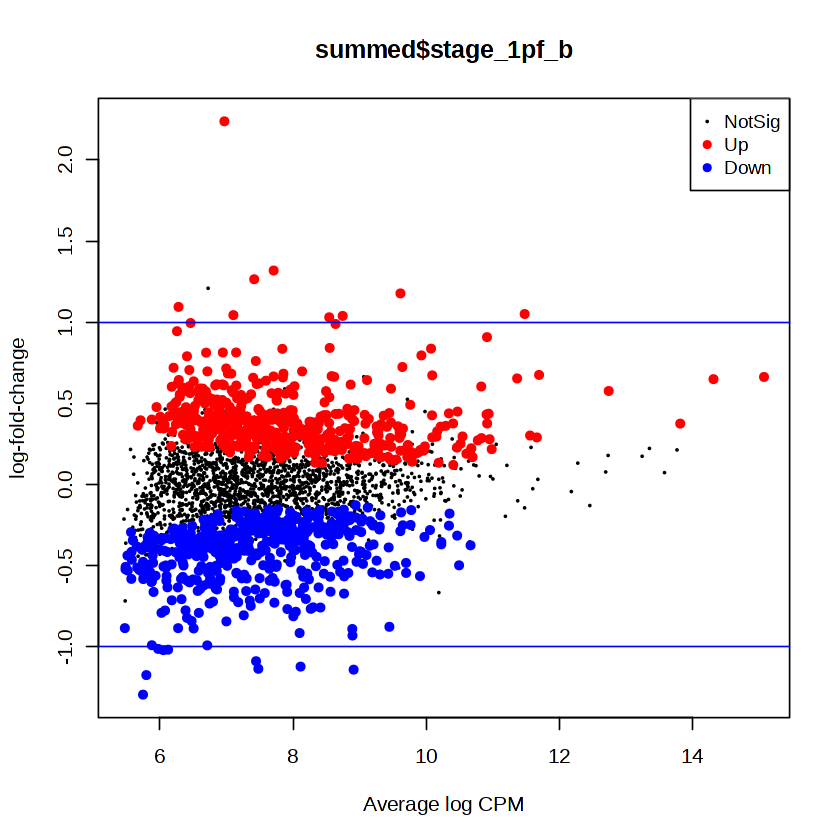

In [31]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

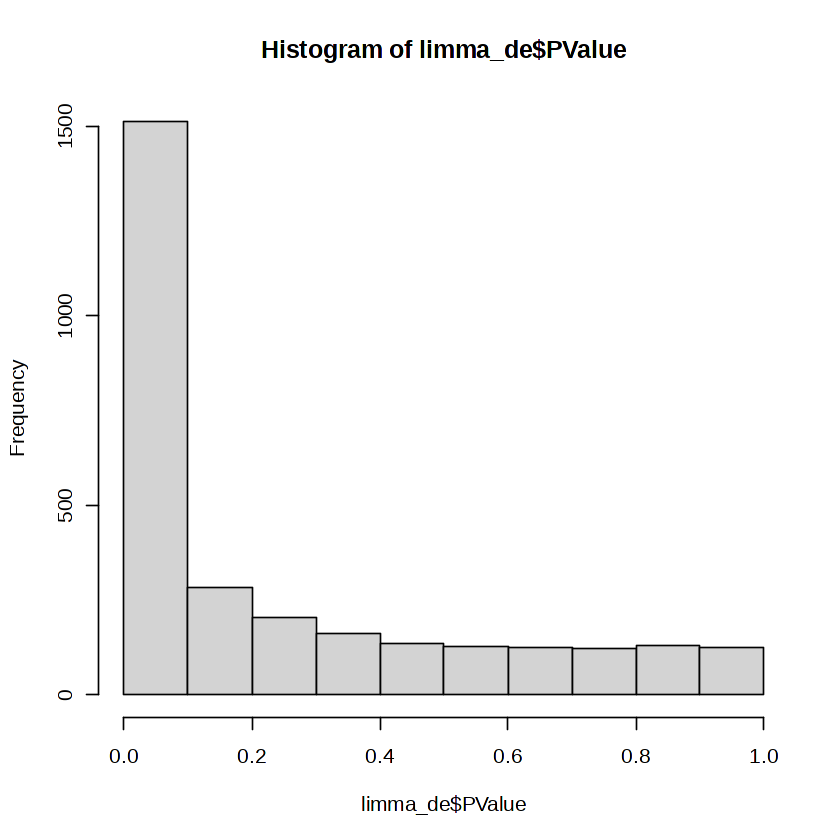

In [32]:
limma_de = qlf$table
limma_de$p.adjust = p.adjust(limma_de$PValue, "bonferroni")
limma_de$BH = p.adjust(limma_de$PValue, "BH")

hist(limma_de$PValue)

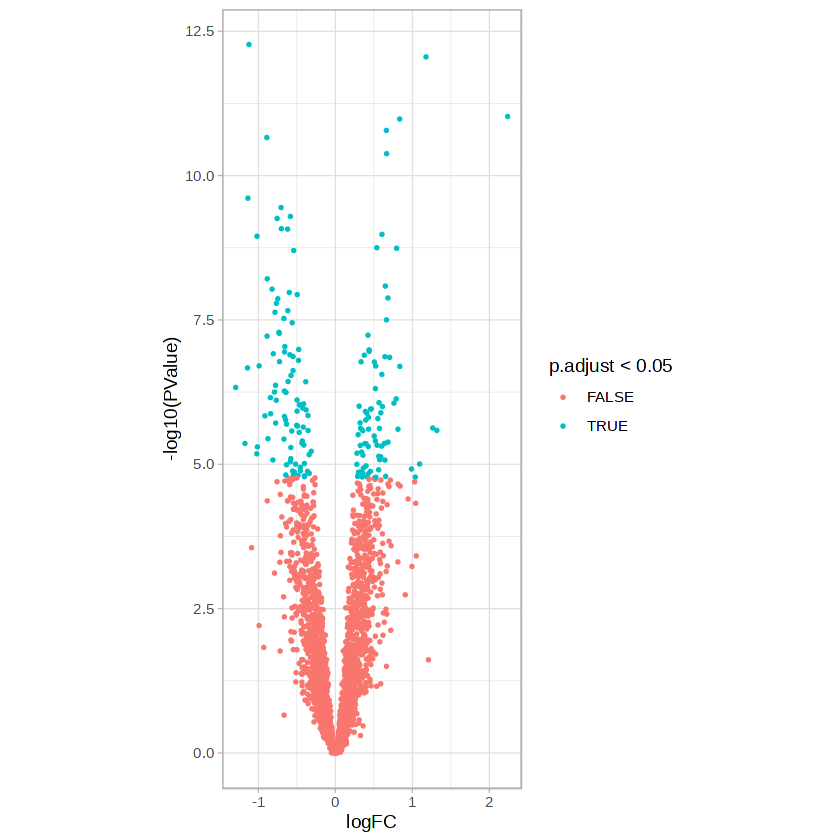

In [33]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = p.adjust < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

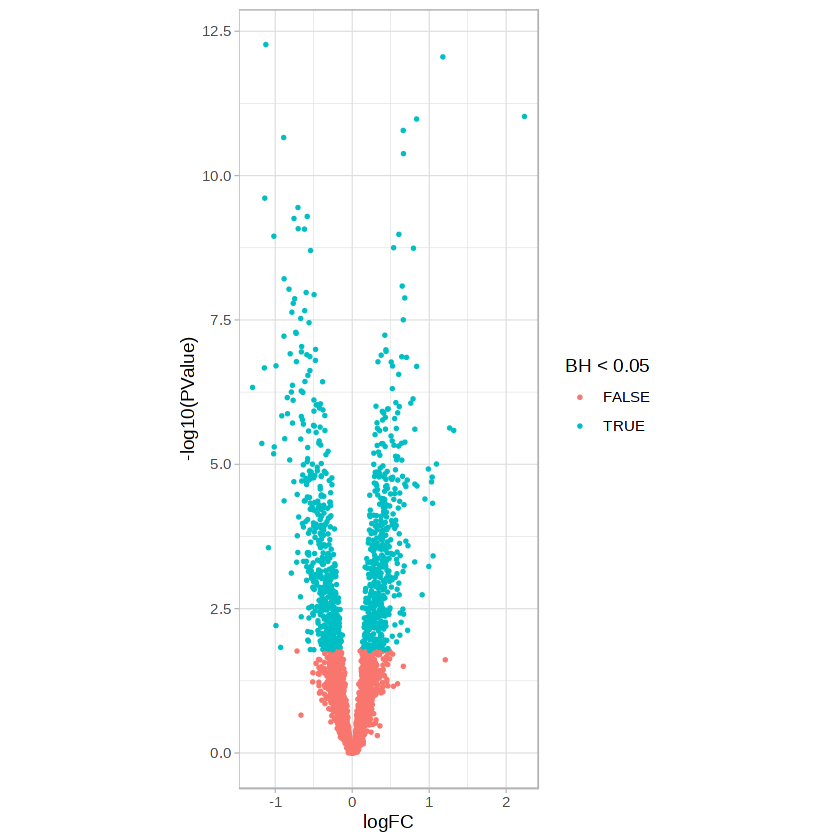

In [34]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = BH < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)